In [1]:
from mne import read_epochs, set_eeg_reference, compute_rank
from mne.decoding import CSP, UnsupervisedSpatialFilter
from mne.preprocessing import ICA, EOGRegression
import numpy as np
from mne.viz import plot_ica_components
from jupyterthemes.stylefx import set_nb_theme
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
set_nb_theme('gruvboxd')

Load and Preprocessing

In [2]:
import sys
sys.path.append('../../preprocessing')
from load_data import load_raw_to_epochs, get_channel_types

# load_raw_to_epochs('esn.bdf', True)

In [3]:
raw = read_epochs('raw_epo.fif')

Reading C:\Users\Alberto\Documents\BCI\data\esn\raw_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated


In [4]:
raw.copy().filter(1,120, n_jobs=4).plot(n_channels=20, n_epochs=3, scalings=30e-6, events=epochs.events, event_id=epochs.event_id)

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 1804 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 7312 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 7488 out of 7488 | elapsed:   14.9s finished


NameError: name 'epochs' is not defined

Marking bad chanels

In [4]:
bads = ['T8', 'AF7', 'TP7', 'EXG5', 'EXG7', 'Fpz', 'T7', 'FC6']
raw.info['bads'] = bads
raw.drop([56, 65, 66, 68])

Dropped 4 epochs: 56, 65, 66, 68


Number of events,100
Events,left: 19r_pinch: 20r_stop: 19rest: 22right: 20
Time range,-2.000 – 7.999 sec
Baseline,off


Referencing

In [5]:
referenced = set_eeg_reference(raw, ref_channels='average')[0]
del raw

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Set channel types

In [6]:
referenced.set_channel_types(get_channel_types())

Number of events,100
Events,left: 19r_pinch: 20r_stop: 19rest: 22right: 20
Time range,-2.000 – 7.999 sec
Baseline,off


Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 2060 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 6312 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 6400 out of 6400 | elapsed:    8.7s finished


Using matplotlib as 2D backend.


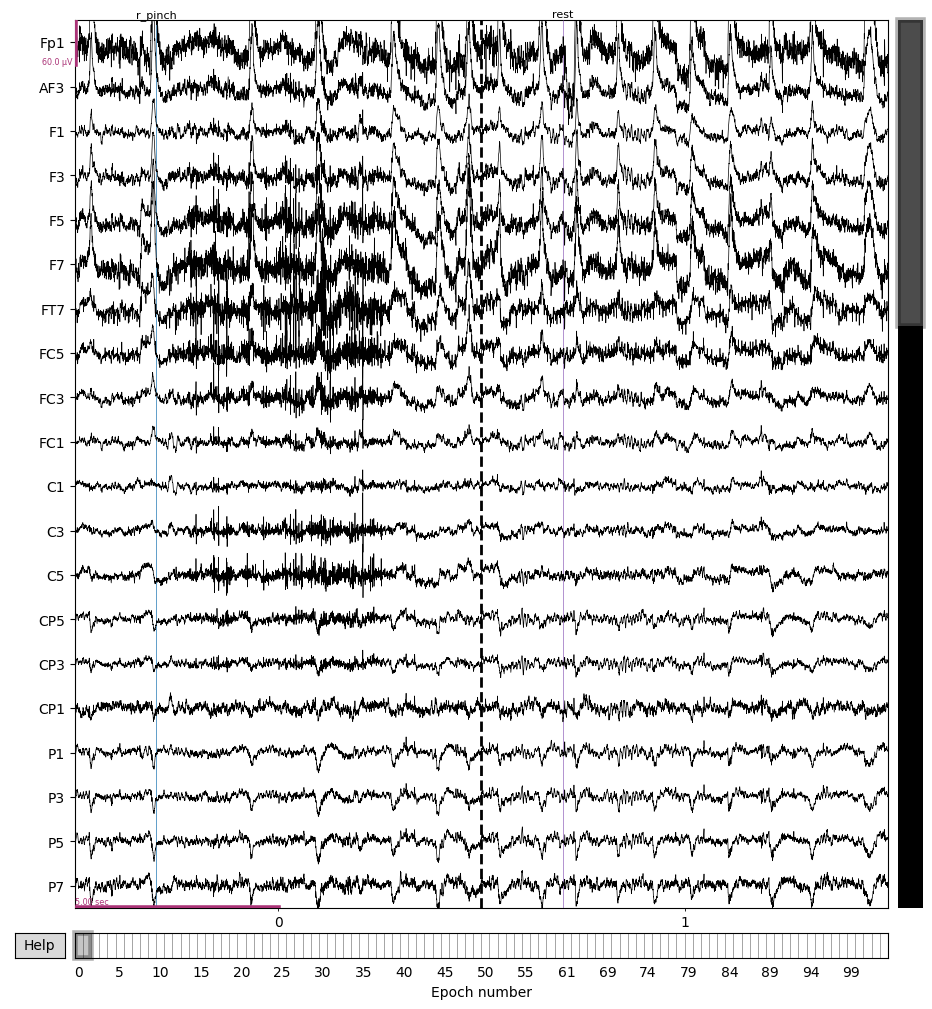

In [7]:
referenced.copy().filter(1,120, n_jobs=4).plot(n_channels=20, n_epochs=2, scalings=30e-6, events=referenced.events, event_id=referenced.event_id)
print()

EOG Regression


No projector specified for this dataset. Please consider the method self.add_proj.


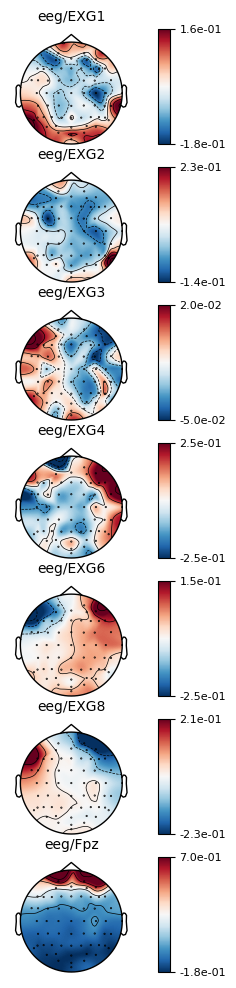

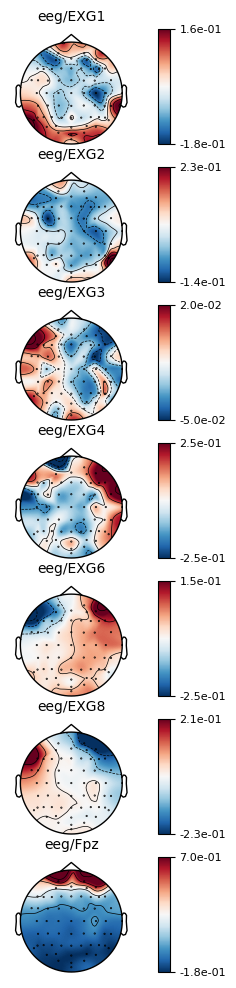

In [7]:
print()
emg_eog = ['EXG1','EXG2','EXG3','EXG4','EXG6','EXG8','Fpz']
regressor = EOGRegression(
    picks='eeg', picks_artifact= emg_eog).fit(referenced)
regressor.plot()
# referenced = regressor.apply(referenced)
# referenced.info['bads'] += ['Fpz']

In [8]:
referenced.save('referenced_epo.fif', overwrite=True)
del referenced

Overwriting existing file.


REMOVE ARTIFACTS


In [9]:
epochs = read_epochs('referenced_epo.fif')
epochs

Reading C:\Users\Alberto\Documents\BCI\data\esn\referenced_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated


Number of events,100
Events,left: 19r_pinch: 20r_stop: 19rest: 22right: 20
Time range,-2.000 – 7.999 sec
Baseline,off



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\Alberto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


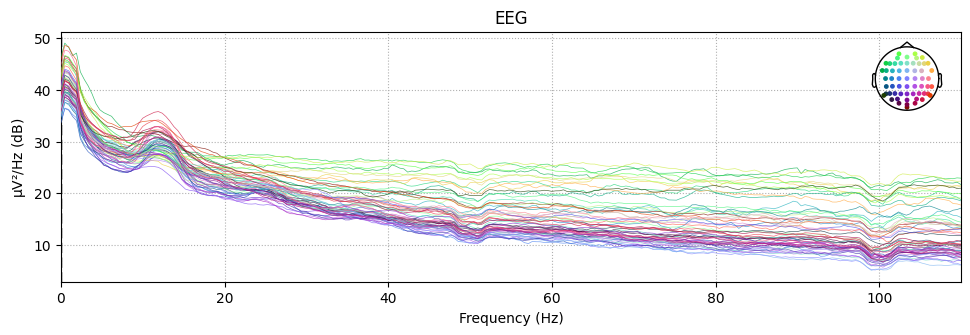

In [13]:
print()
epochs['right','left'].copy().crop(-1,2).plot_psd(fmax=110, tmin=-.1, tmax=2)

ICA

In [10]:
filtered = epochs.copy().filter(1,250, n_jobs=8)
filtered.apply_baseline((-1.4,-0.1))
filtered.crop(0,5)
ica = ICA(n_components=.9, method='picard')
ica.fit(filtered)

Setting up band-pass filter from 1 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 62.50 Hz (-6 dB cutoff frequency: 281.25 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 646 tasks      | elapsed:    8.2s
[Parallel(n_jobs=8)]: Done 5975 tasks      | elapsed:   14.6s
[Parallel(n_jobs=8)]: Done 6400 out of 6400 | elapsed:   15.1s finished


Applying baseline correction (mode: mean)
Fitting ICA to data using 58 channels (please be patient, this may take a while)


C:\Users\Alberto\AppData\Local\Temp\ipykernel_7872\3273349700.py:5: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(filtered)


Selecting by explained variance: 4 components
Fitting ICA took 21.6s.


Method,picard
Fit,37 iterations on epochs (512100 samples)
ICA components,4
Available PCA components,58
Channel types,eeg
ICA components marked for exclusion,—


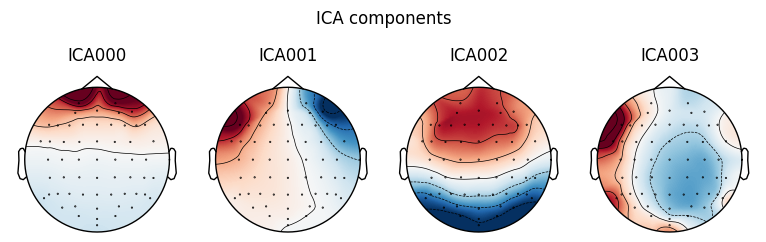

[<MNEFigure size 780x260.5 with 4 Axes>]

In [11]:
print()
plot_ica_components(ica)


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated


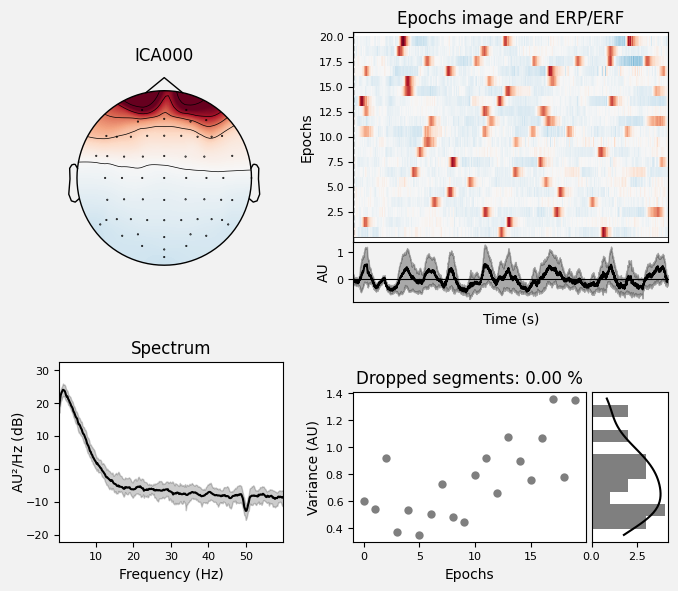

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated


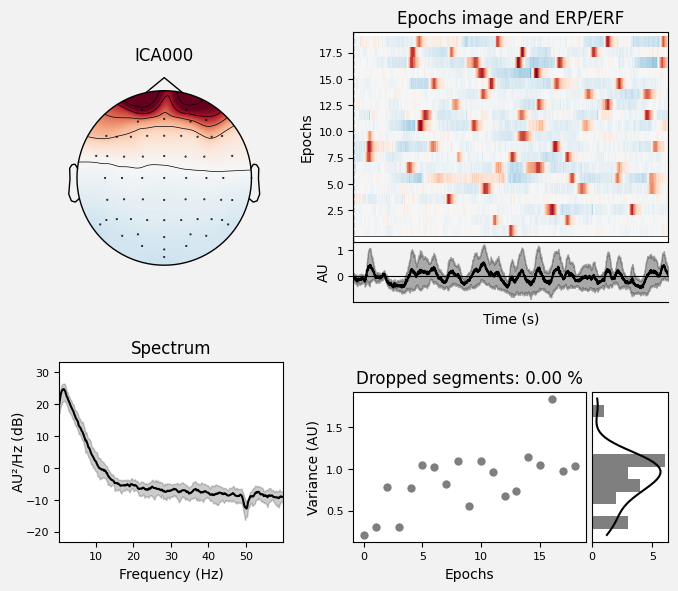

next
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated


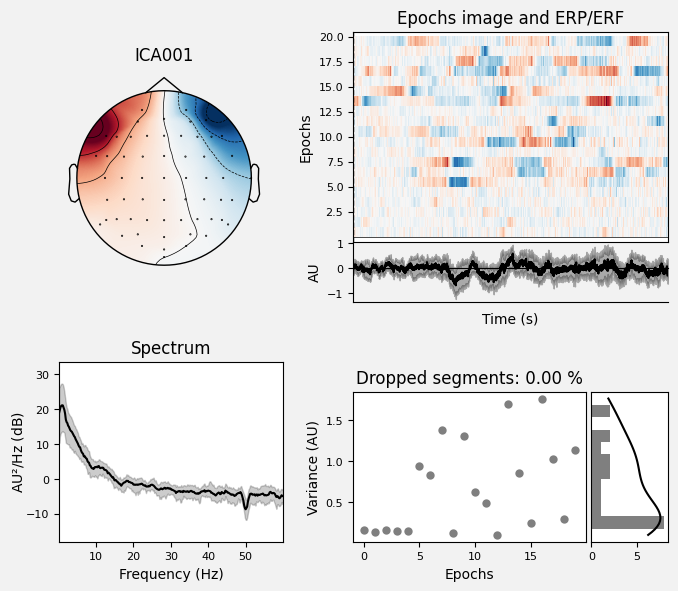

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated


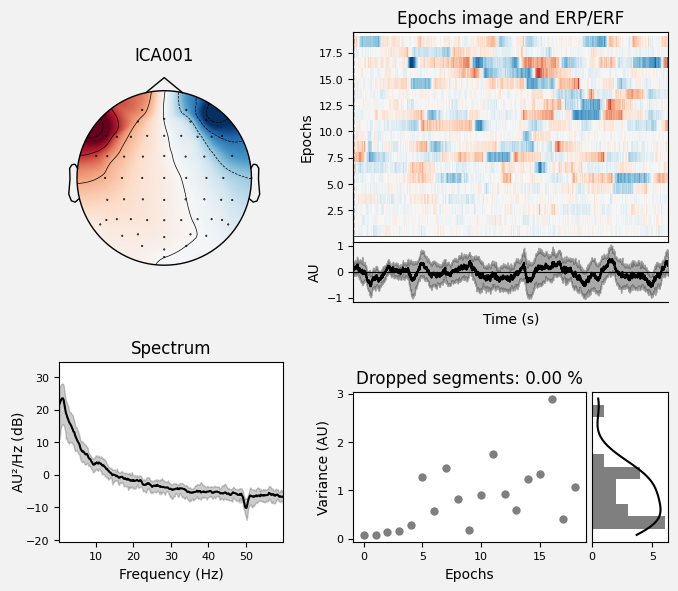

next
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated


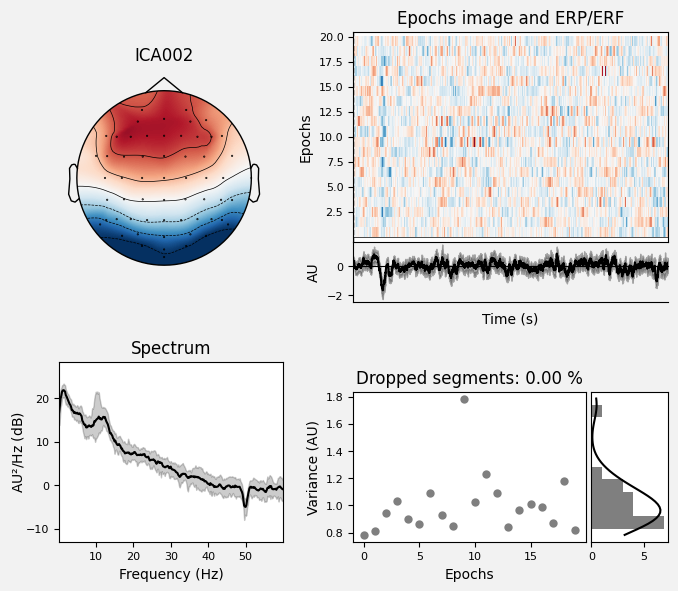

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated


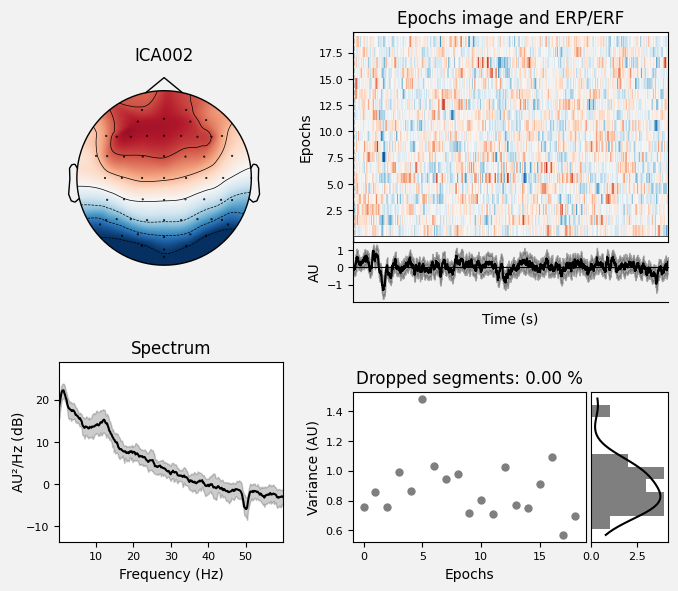

next
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated


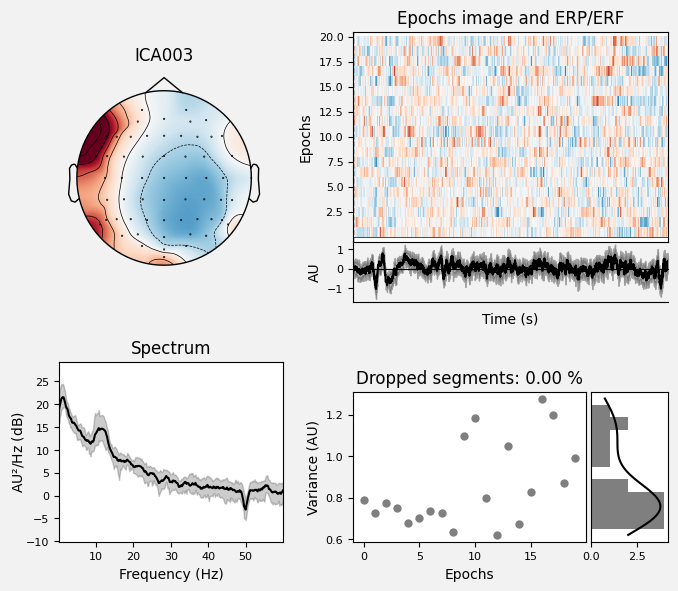

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated


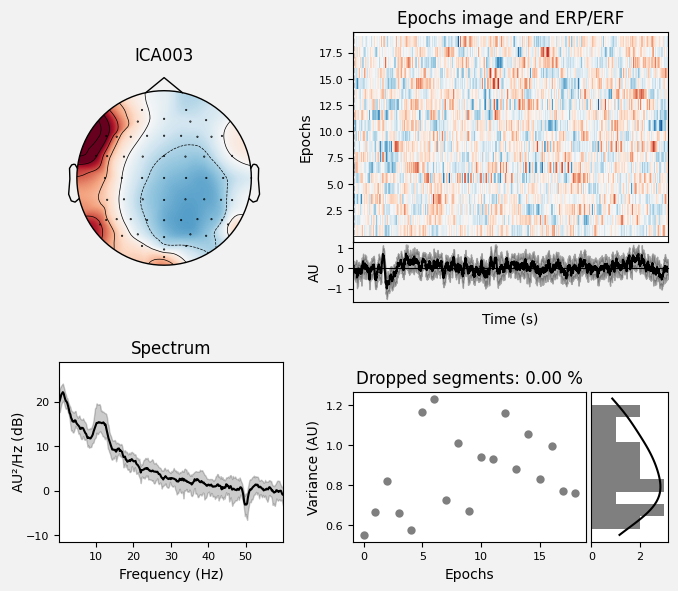

next


In [12]:
for i in np.arange(4):
    ica.plot_properties(
        epochs['r_pinch'].copy().crop(0,5).filter(1,240, verbose=False), 
        picks = [i], 
        log_scale = False,
        psd_args = dict(fmin=.1, fmax=60))

    ica.plot_properties(
        epochs['r_stop'].copy().crop(0,5).filter(1,240, verbose=False), 
        picks = [i], 
        log_scale = False,
        psd_args = dict(fmin=.1, fmax=60))
    
    print('next')

In [13]:
ica.apply(epochs, exclude= [0,1])

Applying ICA to Epochs instance
    Transforming to ICA space (4 components)
    Zeroing out 2 ICA components
    Projecting back using 58 PCA components


Number of events,100
Events,left: 19r_pinch: 20r_stop: 19rest: 22right: 20
Time range,-2.000 – 7.999 sec
Baseline,off


ERP

Setting up band-pass filter from 1 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 62.50 Hz (-6 dB cutoff frequency: 281.25 Hz)
- Filter length: 3381 samples (3.302 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_7872\2041666621.py:1: RuntimeWarning: filter_length (3381) is longer than the signal (2561), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['left','right'].copy().crop(-0.5,2).filter(1,250, n_jobs=8).average().plot()
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done 709 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 2426 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 2496 out of 2496 | elapsed:    7.0s finished


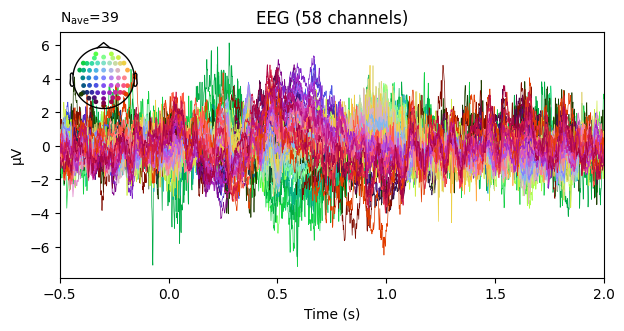

In [14]:
epochs['left','right'].copy().crop(-0.5,2).filter(1,250, n_jobs=8).average().plot()
print()

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_7872\2447180343.py:1: RuntimeWarning: filter_length (3381) is longer than the signal (2561), distortion is likely. Reduce filter length or filter a longer signal.
  epochs['rest'].copy().crop(-0.5,2).filter(1,120, n_jobs=8).average().plot()
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 928 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1408 out of 1408 | elapsed:    0.8s finished


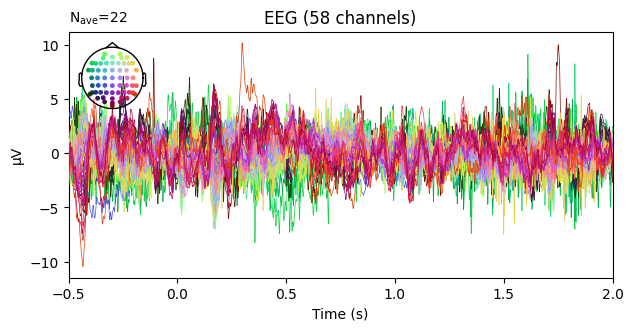

In [15]:
epochs['rest'].copy().crop(-0.5,2).filter(1,120, n_jobs=8).average().plot()
print()

CSP 

In [19]:
le = LabelEncoder()
subset = epochs['left','rest'].copy()
subset.apply_baseline((-1.,-0.1))
subset.drop_channels(epochs.info['bads'])
subset = subset.pick(['eeg'])
y = le.fit_transform(subset.events[:,2])

Applying baseline correction (mode: mean)


In [20]:
pca = UnsupervisedSpatialFilter(PCA(len(subset.info['chs'])), average=False)
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False, rank='info')
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)

Computing rank from data with rank='info'
    MAG: rank 58 after 0 projectors applied to 58 channels
Reducing data rank from 58 -> 58
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 58 after 0 projectors applied to 58 channels
Reducing data rank from 58 -> 58
Estimating covariance using EMPIRICAL
Done.


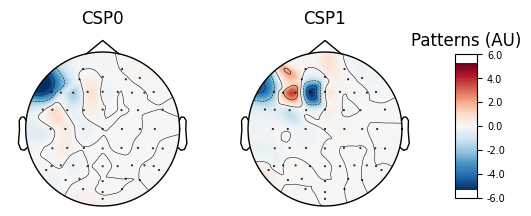

In [21]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(5, 20, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

Computing rank from data with rank='info'
    MAG: rank 58 after 0 projectors applied to 58 channels
Reducing data rank from 58 -> 58
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 58 after 0 projectors applied to 58 channels
Reducing data rank from 58 -> 58
Estimating covariance using EMPIRICAL
Done.


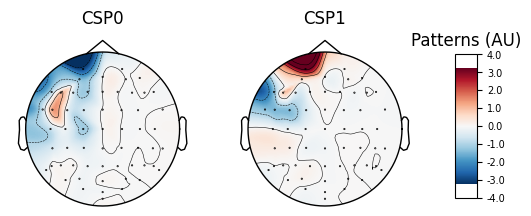

In [22]:
x = pca.fit_transform(subset.copy().crop(-0.1,2).filter(20, 35, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

Computing rank from data with rank='info'
    MAG: rank 58 after 0 projectors applied to 58 channels
Reducing data rank from 58 -> 58
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='info'
    MAG: rank 58 after 0 projectors applied to 58 channels
Reducing data rank from 58 -> 58
Estimating covariance using EMPIRICAL
Done.


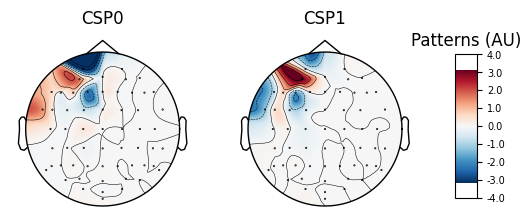

In [23]:
x = pca.fit_transform(subset.copy().crop(-0.1,1.8).filter(70, 90, n_jobs=4, verbose=False).get_data(),y)
csp.fit(x,y)
csp.plot_patterns(subset.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print()

In [16]:
epochs.save('ica_epo.fif', overwrite=True)

Overwriting existing file.
